In [ ]:
import os
import datetime
import numpy as np
import pandas as pd

import omegaconf

import torch
import torch.nn as nn
from pytorch_lightning import Trainer

from AmbiSplice import data_utils
from AmbiSplice import visual_utils
from AmbiSplice import utils

import importlib
import run_ambisplice
importlib.reload(run_ambisplice.model)
importlib.reload(run_ambisplice.dataset)
importlib.reload(run_ambisplice.litmodule)
importlib.reload(run_ambisplice)

<module 'run_ambisplice' from '/home/xqiu/bench/AmbiSplice/run_ambisplice.py'>

In [ ]:
cfg_path = os.path.join(os.getcwd(), 'configs', 'train.yaml')
main_cfg = omegaconf.OmegaConf.load(cfg_path)

omegaconf.OmegaConf.set_struct(main_cfg, False)  # allow new attribute assignment

accelerator, devices = run_ambisplice.get_accelerator_devices(gpus=main_cfg.gpus)

torch_model = run_ambisplice.get_torch_model(main_cfg.model)
lit_run = run_ambisplice.get_lit_run(main_cfg.litrun, torch_model)

lit_data = run_ambisplice.get_lit_data(main_cfg.dataset, main_cfg.dataloader)

Available accelerator: cuda; devices: [0]
Train set size: 22302
Validation set size: 4469
Test set size: 10861
Using stratified sampling based on column: chrom
Found 20 groups for stratified sampling, e.g., ['chr10', 'chr11', 'chr12', 'chr13', 'chr14']...
SpliceDataset summary:
               training: False
           len(meta_df): 22302
             epoch_size: 32000
               data_dir: 
              cache_dir: /tmp
            min_quality: None
    customized_sampling: True
    stratified_sampling: True
     stratified_ngroups: 20, e.g., ['chr10', 'chr11', 'chr12', 'chr13', 'chr14']...
      weighted_sampling: None
        dynamic_weights: False
Using stratified sampling based on column: chrom
Found 20 groups for stratified sampling, e.g., ['chr10', 'chr11', 'chr12', 'chr13', 'chr14']...
Using stratified sampling based on column: chrom
Found 5 groups for stratified sampling, e.g., ['chr1', 'chr3', 'chr5', 'chr7', 'chr9']...


In [7]:
trainer = lit_run.fit(lit_data, accelerator=accelerator, devices=devices, save_cfg=main_cfg)

wandb: Currently logged in as: qiuresearch (qiulab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/xqiu/anaconda3/envs/ambisplice/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /home/xqiu/bench/AmbiSplice/checkpoints/PangolinSingle_2025-10-06_20-08-33_9x9mjwrj exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params | Mode 
-------------------------------------------------
0 | model | PangolinSingle | 696 K  | train
-------------------------------------------------
696 K     Trainable params
0         Non-trainable params
696 K     Total params
2.787     Total estimated model params size (MB)
91        Modules in train mode
0         Modules in eval mode


Using CosineAnnealingWarmRestarts learning rate scheduler...
Sanity Checking: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

/home/xqiu/anaconda3/envs/ambisplice/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
trainer = Trainer()
predictions = trainer.predict(lit_run, datamodule=lit_data)

socket.send() raised exception.
socket.send() raised exception.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


socket.send() raised exception.
socket.send() raised exception.


socket.send() raised exception.
socket.send() raised exception.


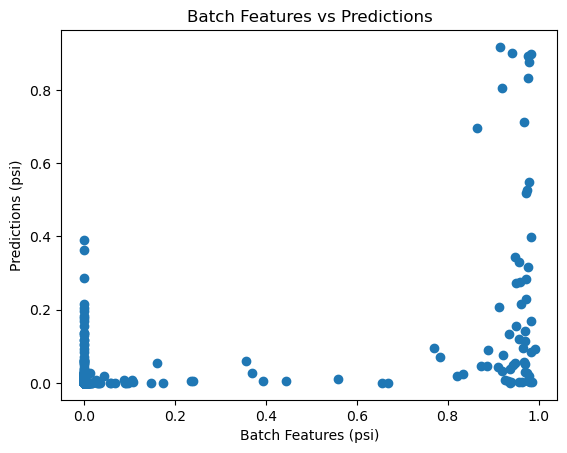

socket.send() raised exception.
socket.send() raised exception.


In [14]:
import matplotlib.pyplot as plt

batch_feats, preds = predictions[0]

plt.scatter(batch_feats['psi'], preds['psi'])
# plt.scatter(batch_feats['cls'], preds['cls'])
plt.xlabel('Batch Features (psi)')
plt.ylabel('Predictions (psi)')
plt.title('Batch Features vs Predictions')
plt.show()

In [ ]:
#Load the Pretrained Model
og_model = model.Pangolin(L=L, W=W, AR=AR)
state_dict = torch.load("Model/final.5.7.3", map_location=accelerator, weights_only=True)
og_model.load_state_dict(state_dict)

# Move model to GPU################
og_model.to(accelerator)
###################################
# ⛳ CRITICAL: Check device of model weights
print("Model device:", next(og_model.parameters()).device)

Model device: cuda:0


In [ ]:
# Load preprocessed training data
training_data_path = "2027_training_data_sequece_exp.pt"  #"102_training_data_sequece_exp.pt"
data = torch.load(training_data_path, weights_only=True)
training_input =  torch.stack(data['X'])  # Each: [N, 4, 15000] # Input:
training_label = torch.stack(data['y'])  # Each: [N, 12, 5000] # Label:

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
input_data = training_input.to(accelerator)
#og_output = og_model(input_data)

### training_label vs predicted visual

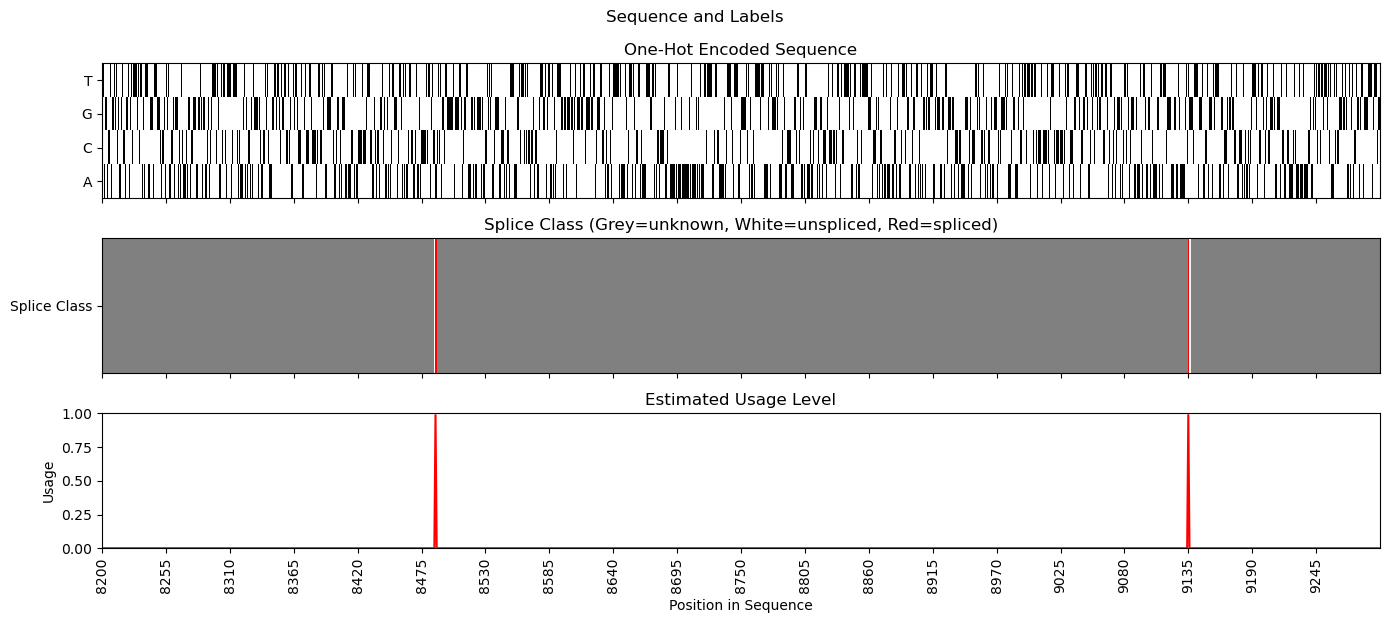

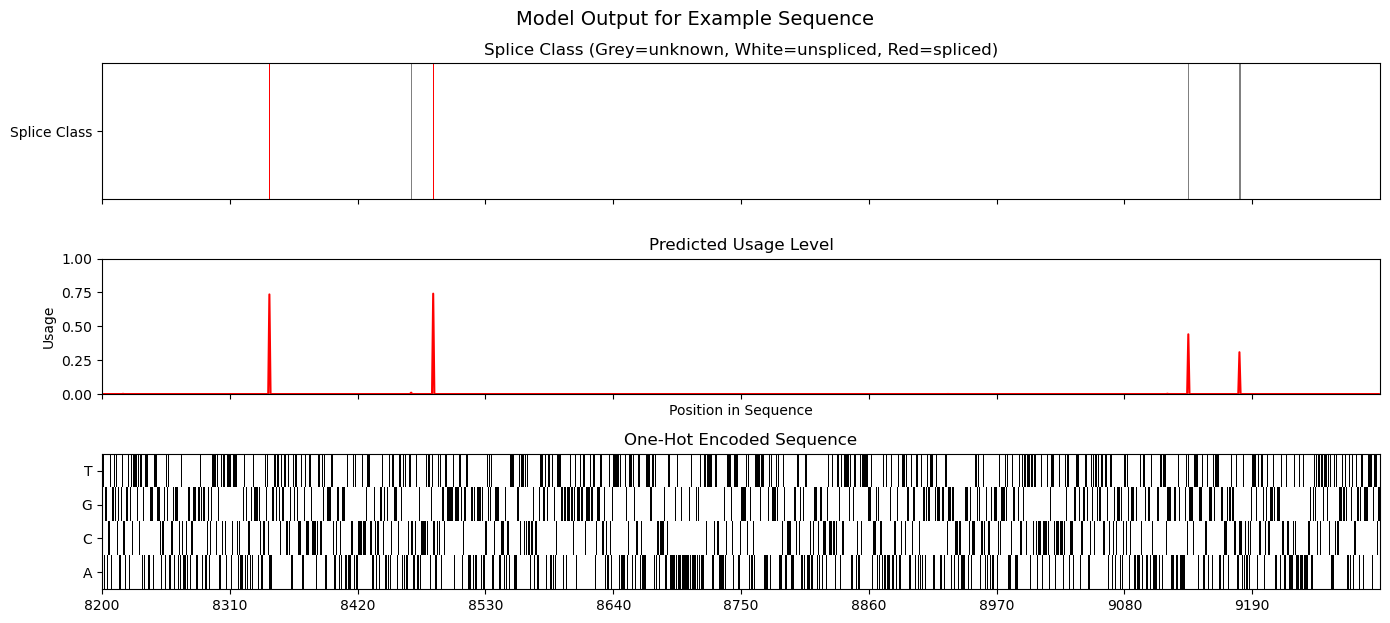

In [21]:
cor_start = 8200
cor_end = 9300
plot_one_hot_and_labels_zoom(training_input[0], training_label[0], zoom_start=cor_start, zoom_end=cor_end, title="Sequence and Labels")

plot_one_hot_and_predictions_zoom(
    one_hot_array=training_input[0], 
    prediction_array=og_output[0].detach().cpu()[0:3, :], 
    zoom_start=cor_start, zoom_end=cor_end,
    title="Model Output for Example Sequence"
)

## Training Module

In [ ]:
#import torch
#import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F

# ----- Example Model (Pangolin-style CNN) -----
class PangolinLikeModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 64, kernel_size=7, padding=3)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.out = nn.Conv1d(64, 3, kernel_size=1)  # Output: 3 channels (unspliced, spliced, usage)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.out(x)  # shape: (batch, 3, 15000)
        x = x.permute(0, 2, 1)  # → (batch, 15000, 3)
        return x


training_input = training_input[:, 0:4, :].to(accelerator)

# For [N, C, L] the padding is (0, 0) on last dim (L), and (0, 9) on channels (C)
training_label_padded = F.pad(training_label, pad=(0, 0, 0, 9))  # shape becomes [105, 12, 15000]
training_label_corped = training_label_padded[:, :, 5000:10000]

dataset = TensorDataset(training_input, training_label_corped)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# ----- Setup -----
accelerator = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.Pangolin(L=L, W=W, AR=AR).to(accelerator)
#model = PangolinEXP(L=L, W=W, AR=AR).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# ----- Training Loop -----
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in dataloader:
        batch_X, batch_y = batch_X.to(accelerator), batch_y.to(accelerator)

        optimizer.zero_grad()
        pred = model(batch_X)  # shape: (batch, 15000, 3)
        loss = loss_fn(pred, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}")

Epoch 1/100, Loss: 0.2511
Epoch 2/100, Loss: 0.1980
Epoch 3/100, Loss: 0.1845
Epoch 4/100, Loss: 0.1788
Epoch 5/100, Loss: 0.1758
Epoch 6/100, Loss: 0.1737
Epoch 7/100, Loss: 0.1721
Epoch 8/100, Loss: 0.1710
Epoch 9/100, Loss: 0.1701
Epoch 10/100, Loss: 0.1695
Epoch 11/100, Loss: 0.1690
Epoch 12/100, Loss: 0.1686
Epoch 13/100, Loss: 0.1683
Epoch 14/100, Loss: 0.1681
Epoch 15/100, Loss: 0.1679
Epoch 16/100, Loss: 0.1678
Epoch 17/100, Loss: 0.1676
Epoch 18/100, Loss: 0.1676
Epoch 19/100, Loss: 0.1675
Epoch 20/100, Loss: 0.1674
Epoch 21/100, Loss: 0.1673
Epoch 22/100, Loss: 0.1673
Epoch 23/100, Loss: 0.1672
Epoch 24/100, Loss: 0.1672
Epoch 25/100, Loss: 0.1672
Epoch 26/100, Loss: 0.1671
Epoch 27/100, Loss: 0.1671
Epoch 28/100, Loss: 0.1671
Epoch 29/100, Loss: 0.1671
Epoch 30/100, Loss: 0.1670
Epoch 31/100, Loss: 0.1670
Epoch 32/100, Loss: 0.1670
Epoch 33/100, Loss: 0.1670
Epoch 34/100, Loss: 0.1670
Epoch 35/100, Loss: 0.1670
Epoch 36/100, Loss: 0.1669
Epoch 37/100, Loss: 0.1669
Epoch 38/1

In [6]:
# ----- Save Model -----
torch.save(model.state_dict(), "Model/2027_sequence_model.pt")
#torch.save(model.state_dict(), "102_samples_sequence_exp_model.pt") #"102_samples_sequence_exp_model.pt")

## Testing on trained model

In [ ]:
#model_demo = PangolinLikeModel()  
model_demo = Pangolin(L=L, W=W, AR=AR)
#Load the Pretrained Model
state_dict = torch.load("demo_pangolin_same_model.pt", map_location=accelerator, weights_only=True)
model_demo.load_state_dict(state_dict)

# Move model to GPU################
model_demo.to(accelerator)
###################################
# ⛳ CRITICAL: Check device of model weights
print("Model device:", next(model_demo.parameters()).device)

/tmp/ipykernel_65901/2115600752.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("demo_pangolin_same_model.pt", map_location=device)


Model device: cuda:0


In [ ]:
input_data = training_input.to(accelerator)
output_demo = model_demo(input_data)

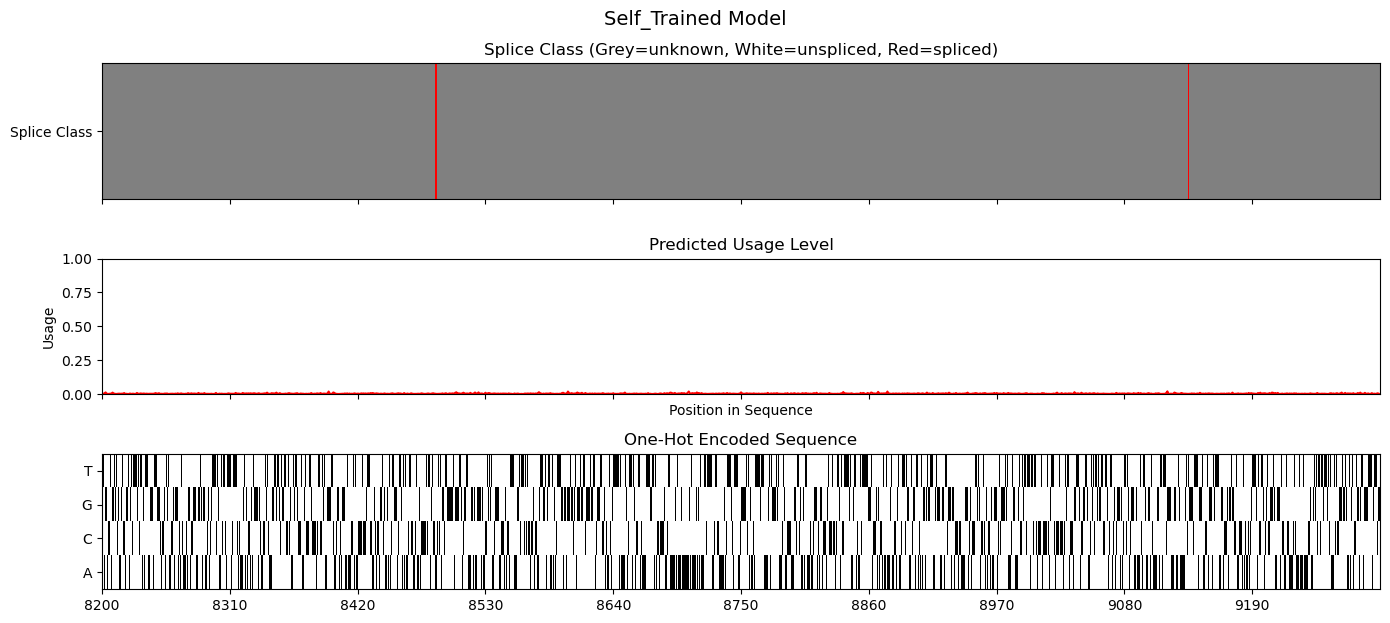

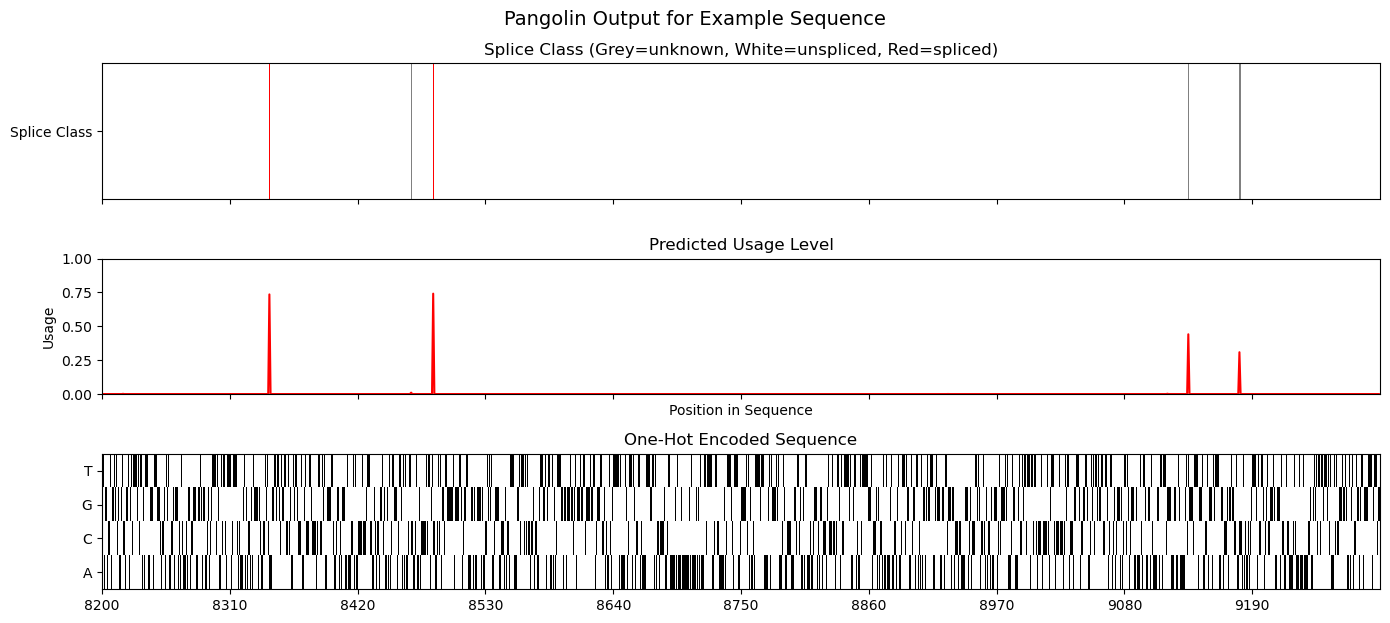

In [22]:
cor_start = 8200
cor_end = 9300

plot_one_hot_and_predictions_zoom(
    one_hot_array=training_input[0], 
    prediction_array=output_demo[0].detach().cpu()[0:3,:], 
    zoom_start=cor_start, zoom_end=cor_end,
    title="Self_Trained Model"
)

plot_one_hot_and_predictions_zoom(
    one_hot_array=training_input[0],   
    prediction_array=og_output[0].detach().cpu()[0:3, :], 
    zoom_start=cor_start, zoom_end=cor_end,
    title="Pangolin Output for Example Sequence"
)

In [16]:
output_demo_0 = output_demo[0].detach().cpu().numpy().T[:, 0:12]
output_demo_0_0 = output_demo_0[:, 0]
output_demo_0_1 = output_demo_0[:, 1]
output_demo_0_2 = output_demo_0[:, 2]

In [21]:
#max(output_demo_0_1)
#max(output_demo_0_2)